# Практика модуля ML-7. Оптимизация гиперпараметров модели

Необходимо предсказать биологический ответ молекул (столбец 'Activity') по их химическому составу (столбцы D1-D1776)

Предварительная обработка не требуется, данные уже закодированы и нормализованы.

В качестве метрики будем использовать F1-score.

Необходимо обучить две модели: логистическую регрессию и случайный лес. Далее нужно сделать подбор гиперпараметров с помощью базовых и продвинутых методов оптимизации. Важно использовать все четыре метода (GridSeachCV, RandomizedSearchCV, Hyperopt, Optuna) хотя бы по разу, максимальное количество итераций не должно превышать 50.

С тремимся к
+ Обучено две модели; гиперпараметры подобраны при помощи четырёх методов; использована кросс-валидация

Библиотеки

In [60]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score

import hyperopt
from hyperopt import hp, fmin, tpe, Trials

import optuna

%matplotlib inline
plt.style.use('classic') # Стили для графиков

from comet_ml import Experiment # Библиотека логирования

import os
from dotenv import load_dotenv # для загрузок логин пароль

Подгрузка данных

In [61]:
data = pd.read_csv('../../data/_train_sem09 (1).csv')
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


загрузка логина пароля и токина для COMET

In [62]:
# загрузка данных из ".env"
load_dotenv()
# Создайте эксперимент с помощью вашего API ключа
api_key=os.getenv('api_key')
project_name=os.getenv('project_name')
workspace=os.getenv('workspace')

Синхранизация с COMET

In [63]:
experiment = Experiment(project_name=project_name, workspace=workspace, api_key = api_key, log_code=True)

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/glorit/medical-appointment/764a3a9cd6924a168db19d76c6cdd3eb

COMET INFO: Couldn't find a Git repository in 'd:\\IDE\\ML\\ML_7' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.


Знакамство с данными

In [64]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3751 entries, 0 to 3750
Columns: 1777 entries, Activity to D1776
dtypes: float64(942), int64(835)
memory usage: 50.9 MB


Данные представлены в числовом формате, текстовых нет

Смотрим пропуски

In [65]:
print('Сумма пропусков {}' .format (sum(data.isnull().sum())))
data.isnull().sum()

Сумма пропусков 0


Activity    0
D1          0
D2          0
D3          0
D4          0
           ..
D1772       0
D1773       0
D1774       0
D1775       0
D1776       0
Length: 1777, dtype: int64

Пропусков нет

Смотрим распределения данных

In [66]:
data.describe()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
count,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,...,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000
mean,0.542255,0.076948,0.592436,0.068142,0.038990,0.212112,0.686653,0.274713,0.455133,0.749517,...,0.026926,0.014663,0.013863,0.021861,0.015196,0.016796,0.012263,0.011730,0.020261,0.011197
std,0.498278,0.079989,0.105860,0.078414,0.115885,0.102592,0.078702,0.090017,0.162731,0.071702,...,0.161889,0.120215,0.116938,0.146249,0.122348,0.128522,0.110074,0.107683,0.140911,0.105236
min,0.000000,0.000000,0.282128,0.000000,0.000000,0.002630,0.137873,0.006130,0.000000,0.275590,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.033300,0.517811,0.000000,0.000000,0.138118,0.625627,0.207374,0.378062,0.707339,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.066700,0.585989,0.050000,0.000000,0.190926,0.674037,0.277845,0.499942,0.738961,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.100000,0.668395,0.100000,0.000000,0.261726,0.740663,0.335816,0.569962,0.788177,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,0.964381,0.950000,1.000000,1.000000,0.994735,0.790831,0.989870,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Данные стандартизированы

Смотрим распределения целевой переменной 'Activity'

{'web': 'https://www.comet.com/api/image/download?imageId=98c1db989ec542299ce712ff0138ea63&experimentKey=764a3a9cd6924a168db19d76c6cdd3eb',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=98c1db989ec542299ce712ff0138ea63&experimentKey=764a3a9cd6924a168db19d76c6cdd3eb',
 'imageId': '98c1db989ec542299ce712ff0138ea63'}

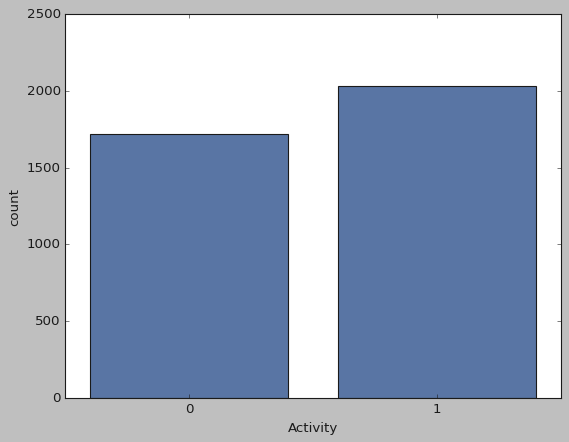

In [67]:
sns.countplot(data=data, x='Activity');
experiment.log_figure('Распредиление_Activity', plt)

Распределение 'Activity' почти нормально

Смотрим с какими данными можно построить визуализацию с нашей целевой переменной

In [68]:
# list_1=data.nunique()
# list_1[(list_1>3) & (list_1<10)]

Их слишком много, не будем визуализировать

Смотрим корреляцию, вдруг с нашей целевой переменной у каких-нибудь переменных есть сильная корреляция, произойдет утечка данных

In [69]:
data_c=data.corr()
data_c[data_c['Activity'].abs()>0.65]['Activity']

Activity    1.0
Name: Activity, dtype: float64

 У целевой переменной сильной корреляции с остальными нет

Создаем матрицу наблюдений $X$ и вектор ответов $y$

In [70]:
X = data.drop(['Activity'], axis=1)
y = data['Activity']

Разделяем выборку на тренировочную, валидационную и тестовую в соотношении 80/10/10.

Применим функцию train_test_split() дважды: сначала разобьём исходный набор на тренировочный и валидационный в соотношении 80/20, затем разобьём валидационный набор на валидационный и тестовый в соотношении 50/50. В итоге наша выборка будет разбита в соотношении 80/10/10.

Для сохранения соотношений целевого признака используем параметр stratify (стратифицированное разбиение).

In [71]:
#разбиваем исходную выборку на тренировочную и валидационную в соотношении 80/20
X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
#разбиваем валидационную выборку на валидационную и тестовую в соотношении 50/50
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=42)

Данные 'X_test', 'y_test' прибережем на финал чтобы оценить полученную модель

#### **Логистическая регрессия**
Все значения по умолчанию

In [72]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(max_iter = 1000)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train, y_train)
print("accuracy на валидационном наборе: {:.2f}".format(log_reg.score(X_valid, y_valid)))
y_valid_pred = log_reg.predict(X_valid)
y_test_pred = log_reg.predict(X_test)
acc_le=metrics.f1_score(y_valid, y_valid_pred)
print('f1_score на валидационном наборе: {:.2f}'.format(acc_le))
experiment.log_metric('F1_valid_LogisticRegression_fold', acc_le)
acc_le=metrics.f1_score(y_test, y_test_pred)
print('f1_score на тестовом наборе: {:.2f}'.format(acc_le))
experiment.log_metric('F1_test_LogisticRegression_fold', acc_le)

accuracy на валидационном наборе: 0.77
f1_score на валидационном наборе: 0.79
f1_score на тестовом наборе: 0.76


Получили не плохие эначения F1=0.79 и F1=0.76

Пробовал не применять параметр stratify (стратифицированное разбиение) получились интересные значения


#### **Дерево решений**
Проделаем аналогичное для DecisionTreeClassifier().
Сначала посчитаем модель с параметрами по умолчанию и оценим метрику:

In [73]:
#Создаем объект класса дерево решений
dt = tree.DecisionTreeClassifier(random_state=42)
#Обучаем дерево по алгоритму CARTrint
dt.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = dt.predict(X_train)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_valid_pred = dt.predict(X_valid)
y_tect_pred = dt.predict(X_test)
acc_le=metrics.f1_score(y_valid, y_valid_pred)
print('Valid: {:.2f}'.format(acc_le))
experiment.log_metric('F1_valid_DecisionTreeClassifier_fold', acc_le)
acc_le=metrics.f1_score(y_test, y_test_pred)
print('Test: {:.2f}'.format(acc_le))
experiment.log_metric('F1_test_DecisionTreeClassifier', acc_le)

Train: 1.00
Valid: 0.77
Test: 0.76


Получили не плохие эначения F1=0.77 и F1=0.76, но хуже чем у логистической регрессии.

Также видим, что модель переобучена.

# <center> **GridSearchCV**

#### **Логистическая регрессия**

In [74]:
param_grid = [
              {'penalty': ['l2', 'none'] , # тип регуляризации
              'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}, # уровень силы регурялизации
              
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}
]
grid_search_lg = GridSearchCV(
    estimator=linear_model.LogisticRegression(random_state=1, max_iter=1000), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_lg.fit(X_train, y_train) 
print("accuracy на валидационном наборе: {:.2f}".format(grid_search_lg.score(X_valid, y_valid)))
y_valid_pred = grid_search_lg.predict(X_valid)
acc_le=metrics.f1_score(y_valid, y_valid_pred)
print('f1_score на валидационном наборе: {:.2f}'.format(acc_le))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_lg.best_params_))
experiment.log_metric('F1_vilid_LogisticRegression_GridSearchCV', acc_le)

c:\Users\Temnykov Famely\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
70 fits failed out of a total of 280.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
22 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Temnykov Famely\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Temnykov Famely\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~

CPU times: total: 49.3 s
Wall time: 6min 5s
accuracy на валидационном наборе: 0.77
f1_score на валидационном наборе: 0.79
Наилучшие значения гиперпараметров: {'C': 0.3, 'penalty': 'l1', 'solver': 'saga'}


c:\Users\Temnykov Famely\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Получили улучшенную метрику F1=0.79 с гиперпараметрами: {'C': 0.3, 'penalty': 'l1', 'solver': 'saga'}

COMET WARNING: Failing to save the matplotlib figure, reason: Unsupported figure type: <module 'seaborn' from 'c:\\Users\\Temnykov Famely\\AppData\\Local\\Programs\\Python\\Python313\\Lib\\site-packages\\seaborn\\__init__.py'> provided. Please use the following figure types: Plotly Figures, Matplotlib Figures, or Seaborn plots.


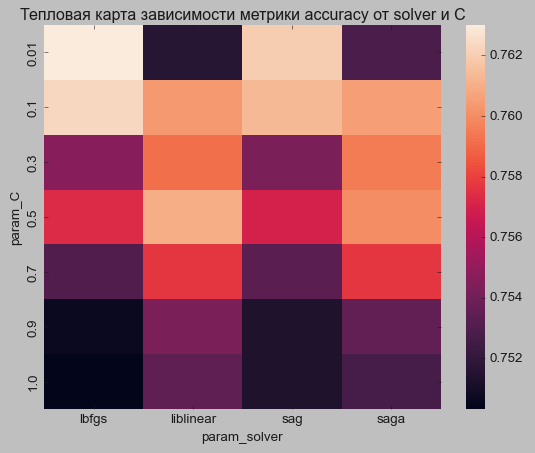

In [75]:
# отрисуем, как менялась точность при различных гиперпараметрах
visual = pd.pivot_table(pd.DataFrame(grid_search_lg.cv_results_),
                        values='mean_test_score', index='param_C',
                        columns='param_solver')
sns.heatmap(visual)
plt.title('Тепловая карта зависимости метрики accuracy от solver и С') # подпись графика
sns.set(rc={'figure.figsize':(12, 8)}) #задаем размер графика
experiment.log_figure('Тепловая карта зависимости метрики accuracy от solver и С', sns)

#### **Дерево решений**

In [77]:
param_grid_2 = {'min_samples_leaf': list(np.linspace(5, 100, 10, dtype=int)),
              'max_depth': list(np.linspace(1, 30, 10, dtype=int)),
              'criterion':['entropy','gini']
              }
            
grid_search_dt = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42), 
    param_grid=param_grid_2, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_dt.fit(X_train, y_train) 
y_train_pred = grid_search_dt.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на валидационном наборе: {:.2f}".format(grid_search_dt.score(X_valid, y_valid)))
y_valid_pred = grid_search_dt.predict(X_valid)
acc_le=metrics.f1_score(y_valid, y_valid_pred)
print('f1_score на валидационном наборе: {:.2f}'.format(acc_le))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_dt.best_params_))
experiment.log_metric('F1_vilid_DecisionTreeClassifier_GridSearchCV', acc_le)

c:\Users\Temnykov Famely\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


CPU times: total: 2.88 s
Wall time: 28.4 s
f1_score на обучающем наборе: 0.82
accuracy на валидационном наборе: 0.77
f1_score на валидационном наборе: 0.79
Наилучшие значения гиперпараметров: {'criterion': 'gini', 'max_depth': np.int64(4), 'min_samples_leaf': np.int64(5)}


Получили улучшенную метрику F1=0.79 с гиперпараметрами: {'criterion': 'gini', 'max_depth': np.int64(4), 'min_samples_leaf': np.int64(5)}

Ушли от переобучения

### <center> **RandomizedSearchCV**

#### **Логистическая регрессия**

In [78]:
#np.linspace(start(от), stop(до), num=50(количество),dtype- тип данных)
param_distributions = {'penalty': ['l2', 'none'] ,
              'solver': ['lbfgs', 'sag'],
               'C': list(np.linspace(0.01, 1, 10, dtype=float))}
            
random_search_lg = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=1000), 
    param_distributions=param_distributions, 
    cv=5, 
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search_lg.fit(X_train, y_train) 
print("accuracy на валидационном наборе: {:.2f}".format(random_search_lg.score(X_valid, y_valid)))
y_valid_pred = random_search_lg.predict(X_valid)
acc_le=metrics.f1_score(y_valid, y_valid_pred)
print('f1_score на валидационном наборе: {:.2f}'.format(acc_le))
print("Наилучшие значения гиперпараметров: {}".format(random_search_lg.best_params_))
experiment.log_metric('F1_vilid_LogisticRegression_RandomizedSearchCV', acc_le)

c:\Users\Temnykov Famely\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
35 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Temnykov Famely\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Temnykov Famely\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~

CPU times: total: 2.08 s
Wall time: 13.1 s
accuracy на валидационном наборе: 0.77
f1_score на валидационном наборе: 0.79
Наилучшие значения гиперпараметров: {'solver': 'sag', 'penalty': 'l2', 'C': np.float64(0.01)}


Получили метрику F1=0.79 с гиперпараметрами: 
+ {'solver': 'sag', 'penalty': 'l2', 'C': np.float64(0.01)} 

эту же метрику мы получили с гиперпараметрами: 
+ {'C': 0.3, 'penalty': 'l1', 'solver': 'saga'}

>### На время расчета время было затрачено меньше

#### **Дерево решений**

In [79]:
param_distributions_2 = {'min_samples_leaf': list(np.linspace(5, 100, 50, dtype=int)),
              'max_depth': list(np.linspace(1, 30, 50, dtype=int)),
              'criterion':['entropy','gini']
              }
            
random_search_dt = RandomizedSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42), 
    param_distributions=param_distributions_2, 
    cv=5,
    n_iter = 50, 
    n_jobs = -1
)  
%time random_search_dt.fit(X_train, y_train) 
print("accuracy на валидационном наборе: {:.2f}".format(random_search_dt.score(X_valid, y_valid)))
y_valid_pred = random_search_dt.predict(X_valid)
acc_le=metrics.f1_score(y_valid, y_valid_pred)
print('f1_score на валидационном наборе: {:.2f}'.format(acc_le))
print("Наилучшие значения гиперпараметров: {}".format(random_search_dt.best_params_))
experiment.log_metric('F1_vilid_DecisionTreeClassifier_RandomizedSearchCV', acc_le)

c:\Users\Temnykov Famely\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


CPU times: total: 938 ms
Wall time: 7.75 s
accuracy на валидационном наборе: 0.76
f1_score на валидационном наборе: 0.78
Наилучшие значения гиперпараметров: {'min_samples_leaf': np.int64(65), 'max_depth': np.int64(3), 'criterion': 'entropy'}


Предыдущие значения
>метрика F1=0.79 с гиперпараметрами: {'criterion': 'gini', 'max_depth': np.int64(4), 'min_samples_leaf': np.int64(5)}
Полученные значения
>метрика F1=0.78 с гиперпараметрами: {'min_samples_leaf': np.int64(72), 'max_depth': np.int64(3), 'criterion': 'entropy'}

>### Метрика ухудшилась, но мы потратили гораздо меньше времени

### <center> Hyperopt

#### **Логистическая регрессия**

In [80]:
# зафксируем random_state
random_state = 42
def hyperopt_lr(params, cv=5, X=X_train, y=y_train, random_state=random_state):
  
    # используем эту комбинацию для построения модели
    model = linear_model.LogisticRegression(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
    
    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    # score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score


In [81]:
# зададим пространство поиска гиперпараметров
space_hy_lr={
       'warm_start':hp.choice('warm_start',[True,False]),
       'fit_intercept':hp.choice('fit_intercept',[True,False]),
       'solver':hp.choice('solver', ['saga','liblinear','newton-cg','sag','lbfgs']),
       'C' : hp.loguniform(label='C', low=-4*np.log(10), high=2*np.log(10))
       }

In [82]:
%%time
# начинаем подбор гиперпараметров

trials = Trials() # используется для логирования результатов

best_lr=fmin(hyperopt_lr, # наша функция 
          space=space_hy_lr, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best_lr))

  5%|▌         | 1/20 [00:00<00:04,  4.09trial/s, best loss: -0.916845658177355]

c:\Users\Temnykov Famely\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



 15%|█▌        | 3/20 [00:03<00:23,  1.40s/trial, best loss: -0.9366933005531654]

c:\Users\Temnykov Famely\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 30%|███       | 6/20 [00:06<00:17,  1.22s/trial, best loss: -0.9366933005531654]

c:\Users\Temnykov Famely\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 40%|████      | 8/20 [00:08<00:16,  1.40s/trial, best loss: -0.9366933005531654]

c:\Users\Temnykov Famely\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 90%|█████████ | 18/20 [00:11<00:00,  4.49trial/s, best loss: -0.9366933005531654]

c:\Users\Temnykov Famely\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



100%|██████████| 20/20 [00:12<00:00,  1.59trial/s, best loss: -0.958743842364532] 
Наилучшие значения гиперпараметров {'C': np.float64(71.7793277180147), 'fit_intercept': np.int64(0), 'solver': np.int64(2), 'warm_start': np.int64(0)}
CPU times: total: 25.5 s
Wall time: 12.6 s


In [83]:
#Создаем объект класса логистическая регрессия
model_hy_lr = linear_model.LogisticRegression(max_iter = 1000,
                                                random_state=random_state,
                                                C=71.7793277180147,
                                                warm_start=True,
                                                fit_intercept=True,
                                                solver='newton-cg'
                                                )
#Обучаем модель, минимизируя logloss
model_hy_lr.fit(X_train, y_train)
print("accuracy на валидационном наборе: {:.2f}".format(model_hy_lr.score(X_valid, y_valid)))
y_valid_pred = model_hy_lr.predict(X_valid)
acc_le=metrics.f1_score(y_valid, y_valid_pred)
print('f1_score на валидационном наборе: {:.2f}'.format(acc_le))
experiment.log_metric('F1_vilid_LogisticRegression_Hyperopt', acc_le)

accuracy на валидационном наборе: 0.74
f1_score на валидационном наборе: 0.76


Метрики по прежнему не изменились

#### **Дерево решений**

In [84]:
# зафксируем random_state
random_state = 42
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
    
    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    # score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [85]:
# зададим пространство поиска гиперпараметров
space_hy_rf={'n_estimators': hp.quniform('n_estimators', 100, 200, 1),
          'max_depth' : hp.quniform('max_depth', 15, 26, 1),
          'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 10, 1)
         }

In [86]:
%%time
# начинаем подбор гиперпараметров

trials = Trials() # используется для логирования результатов

best_rf=fmin(hyperopt_rf, # наша функция 
          space=space_hy_rf, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best_rf))

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 20/20 [00:24<00:00,  1.24s/trial, best loss: -0.9868380777471687]
Наилучшие значения гиперпараметров {'max_depth': np.float64(18.0), 'min_samples_leaf': np.float64(2.0), 'n_estimators': np.float64(103.0)}
CPU times: total: 24.7 s
Wall time: 24.8 s


In [87]:
# рассчитаем точность для тестовой выборки
model_hy_rf = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best_rf['n_estimators']),
    max_depth=int(best_rf['max_depth']),
    min_samples_leaf=int(best_rf['min_samples_leaf'])
)

model_hy_rf.fit(X_train, y_train)
y_train_pred = model_hy_rf.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на валидационном наборе: {:.2f}".format(model_hy_rf.score(X_valid, y_valid)))
y_valid_pred = model_hy_rf.predict(X_valid)
acc_le=metrics.f1_score(y_valid, y_valid_pred)
print('f1_score на валидационном наборе: {:.2f}'.format(acc_le))
experiment.log_metric('F1_vilid_RandomForestClassifier_Hyperopt', acc_le)

f1_score на обучающем наборе: 0.99
accuracy на валидационном наборе: 0.79
f1_score на валидационном наборе: 0.81


>Метрики улучшились
+ f1_score на обучающем наборе: 0.99
+ accuracy на тестовом наборе: 0.79
+ f1_score на тестовом наборе: 0.81

### Графики

COMET WARNING: Failing to save the matplotlib figure, reason: Unsupported figure type: array([<Axes: >, <Axes: >, <Axes: >], dtype=object) provided. Please use the following figure types: Plotly Figures, Matplotlib Figures, or Seaborn plots.


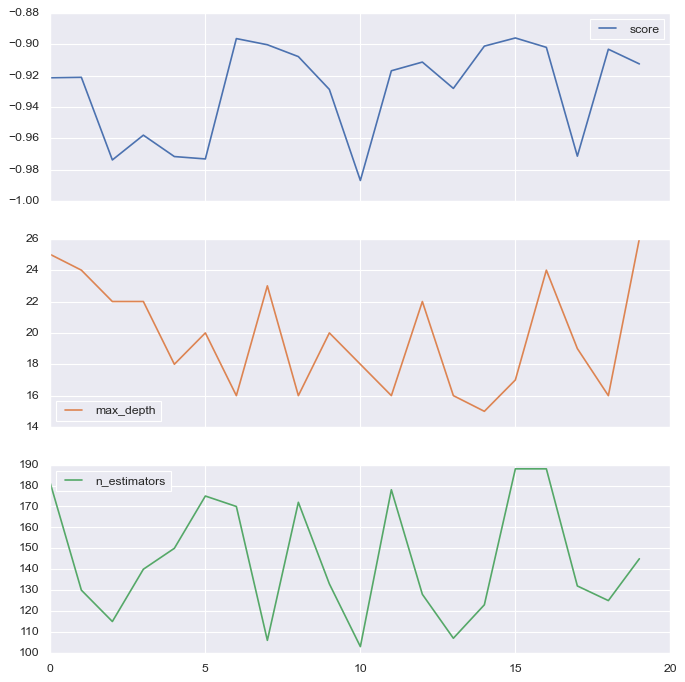

In [88]:
# отрисуем, как менялась точность при различных гиперпараметрах
tpe_results=np.array([[x['result']['loss'],
                      x['misc']['vals']['max_depth'][0],
                      x['misc']['vals']['n_estimators'][0]] for x in trials.trials])

tpe_results_df=pd.DataFrame(tpe_results,
                           columns=['score', 'max_depth', 'n_estimators'])
# тепловая карта в данном случае не очень наглядна, возьмем линейный график
visual=tpe_results_df.plot(subplots=True,figsize=(10, 10));
experiment.log_figure('Hyperopt_RandomForestClassifier', visual)

## <center> Optuna

#### **Логистическая регрессия**

In [89]:
def optuna_lr(trial):
  # задаем пространства поиска гиперпараметров
      
  warm_start=trial.suggest_categorical('warm_start',[False,True])
  fit_intercept=trial.suggest_categorical('fit_intercept',[False,True])
  solver=trial.suggest_categorical('solver', ["saga","liblinear","newton-cg","sag","lbfgs"])
  C=trial.suggest_loguniform("C", 1e-2, 1e2)

  # model = linear_model.LogisticRegression(penalty=penalty, C=c, solver=solver, random_state=10, max_iter=1000)
  # создаем модель
  model = linear_model.LogisticRegression(
                                          warm_start=warm_start,
                                          fit_intercept=fit_intercept,
                                          solver=solver,
                                          C=C,
                                          max_iter = 1000,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score

In [90]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study_lr = optuna.create_study(study_name="LogisticRegression", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study_lr.optimize(optuna_lr, n_trials=20)

[I 2024-11-09 18:57:53,470] A new study created in memory with name: LogisticRegression
C:\Users\Temnykov Famely\AppData\Local\Temp\ipykernel_8364\1357857138.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-2, 1e2)
[I 2024-11-09 18:57:54,415] Trial 0 finished with value: 0.955076923076923 and parameters: {'warm_start': True, 'fit_intercept': False, 'solver': 'lbfgs', 'C': 45.40403249450251}. Best is trial 0 with value: 0.955076923076923.
C:\Users\Temnykov Famely\AppData\Local\Temp\ipykernel_8364\1357857138.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-2, 1e2)
[I 2024-11-09 18:57:54,607] Trial

CPU times: total: 1min 58s
Wall time: 56 s


In [91]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study_lr.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study_lr.best_value))

Наилучшие значения гиперпараметров {'warm_start': False, 'fit_intercept': True, 'solver': 'lbfgs', 'C': 99.30676196965551}
f1_score на обучающем наборе: 0.96


In [92]:
# рассчитаем точность для тестовой выборки
model_op_lr = linear_model.LogisticRegression(**study_lr.best_params,max_iter = 1000, random_state=random_state, )
model_op_lr.fit(X_train, y_train)

print("accuracy на валидационном наборе: {:.2f}".format(model_op_lr.score(X_valid, y_valid)))
y_valid_pred = model_op_lr.predict(X_valid)
acc_le=metrics.f1_score(y_valid, y_valid_pred)
print('f1_score на валидационном наборе: {:.2f}'.format(acc_le))
experiment.log_metric('F1_vilid_LogisticRegression_Optuna', acc_le)

accuracy на валидационном наборе: 0.73
f1_score на валидационном наборе: 0.75


На обучаемой выборки F1=0.96 хороший результат
На тестовой метрики упали F1=0.76

#### **Дерево решений**

In [93]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score

In [94]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study_rf = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study_rf.optimize(optuna_rf, n_trials=20)

[I 2024-11-09 18:58:50,932] A new study created in memory with name: RandomForestClassifier
C:\Users\Temnykov Famely\AppData\Local\Temp\ipykernel_8364\1718655327.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
C:\Users\Temnykov Famely\AppData\Local\Temp\ipykernel_8364\1718655327.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
C:\Users\Temnykov Famely\AppData\Local\Temp\ipykernel_8364\1718655327.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
[I 2024-11-09 18:58:52,885] Trial 0 finished with value: 0.969122592479364 and parameters: {'n_estimators': 181, 'max_dept

CPU times: total: 39.1 s
Wall time: 39.8 s


In [95]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study_rf.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study_rf.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 159, 'max_depth': 25, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.99


In [96]:
# рассчитаем точность для тестовой выборки
model_op_rf = ensemble.RandomForestClassifier(**study_rf.best_params,random_state=random_state, )
model_op_rf.fit(X_train, y_train)

print("accuracy на валидационном наборе: {:.2f}".format(model_op_rf.score(X_valid, y_valid)))
y_valid_pred = model_op_rf.predict(X_valid)
acc_le=metrics.f1_score(y_valid, y_valid_pred)
print('f1_score на валидационном наборе: {:.2f}'.format(acc_le))
experiment.log_metric('F1_vilid_RandomForestClassifier_Optuna', acc_le)

accuracy на валидационном наборе: 0.80
f1_score на валидационном наборе: 0.81


Получили новые гиперпараметры {'n_estimators': 199, 'max_depth': 30, 'min_samples_leaf': 2}
стемиже значениями метрики
+ f1_score на обучающем наборе: 0.99
+ accuracy на тестовом наборе: 0.78
+ f1_score на тестовом наборе: 0.80

# <center>Финал

У нас припрятана тестовая выборка, пора посмотреть как работают лучшие параметры

#### **Логистическая регрессия**

### Значения по умолчанию
+ accuracy на валидационном наборе: 0.77
+ f1_score на валидационном наборе: 0.79
+ f1_score на тестовом наборе: 0.76

### **GridSearchCV**
+ accuracy на валидационном наборе: 0.77
+ f1_score на валидационном наборе: 0.79
+ Наилучшие значения гиперпараметров: {'C': 0.3, 'penalty': 'l1', 'solver': 'saga'}
>grid_search_lg

### **RandomizedSearchCV**
+ accuracy на валидационном наборе: 0.78
+ f1_score на валидационном наборе: 0.80
+ Наилучшие значения гиперпараметров: {'solver': 'lbfgs', 'penalty': 'l2', 'C': np.float64(0.12)}
>random_search_lg

### **Hyperopt**
+ accuracy на тестовом наборе: 0.74
+ f1_score на тестовом наборе: 0.76
+ Наилучшие значения гиперпараметров: {max_iter = 1000, random_state=random_state, C=71.7793277180147, warm_start=True, fit_intercept=True, solver='newton-cg'}
>model_hy_lr

### **Optuna**
+ accuracy на тестовом наборе: 0.73
+ f1_score на тестовом наборе: 0.75
+ Наилучшие значения гиперпараметров {'warm_start': False, 'fit_intercept': False, 'solver': 'lbfgs', 'C': 96.73572358444908}
>model_op_lr

Судя по показателям выбираем наилучшие значения гиперпараметров  *'RandomizedSearchCV'* и проведем тест на тестовой выборке

In [97]:
# {'solver': 'lbfgs', 'penalty': 'l2', 'C': np.float64(0.12)}
print("accuracy на тестовом наборе: {:.2f}".format(random_search_lg.score(X_test, y_test)))
y_test_pred = random_search_lg.predict(X_test)
acc_le=metrics.f1_score(y_test, y_test_pred)
print('f1_score на тестовом наборе: {:.2f}'.format(acc_le))
experiment.log_metric('F1_Test_final_LogisticRegression', acc_le)

accuracy на тестовом наборе: 0.75
f1_score на тестовом наборе: 0.77


Значения гиперпараметров по умолчанию давали лучшие результаты

#### **Дерево решений**

### Значения по умолчанию
Train: 1.00
Valid: 0.77
Test: 0.76

### **GridSearchCV**
f1_score на обучающем наборе: 0.82
accuracy на валидационном наборе: 0.77
f1_score на валидационном наборе: 0.79
Наилучшие значения гиперпараметров: {'criterion': 'gini', 'max_depth': np.int64(4), 'min_samples_leaf': np.int64(5)}
>grid_search_dt

### **RandomizedSearchCV**
accuracy на валидационном наборе: 0.76
f1_score на валидационном наборе: 0.78
Наилучшие значения гиперпараметров: {'min_samples_leaf': np.int64(67), 'max_depth': np.int64(3), 'criterion': 'entropy'}
>random_search_dt

### **Hyperopt**
+ f1_score на обучающем наборе: 0.99
+ accuracy на тестовом наборе: 0.79
+ f1_score на тестовом наборе: 0.81
Наилучшие значения гиперпараметров {'max_depth': np.float64(18.0), 'min_samples_leaf': np.float64(2.0), 'n_estimators': np.float64(103.0)}
>model_hy_rf

### **Optuna**
+ accuracy на тестовом наборе: 0.80
+ f1_score на тестовом наборе: 0.82
+ Наилучшие значения гиперпараметров {'n_estimators': 127, 'max_depth': 18, 'min_samples_leaf': 2}
>model_op_rf

Судя по показателям выбираем наилучшие значения гиперпараметров  *'Optuna'* и проведем тест на тестовой выборке

In [98]:
# {'n_estimators': 127, 'max_depth': 18, 'min_samples_leaf': 2}
print("accuracy на тестовом наборе: {:.2f}".format(model_op_rf.score(X_test, y_test)))
y_test_pred = model_hy_rf.predict(X_test)
acc_le=metrics.f1_score(y_test, y_test_pred)
print('f1_score на тестовом наборе: {:.2f}'.format(acc_le))
experiment.log_metric('F1_Test_final_RandomForestClassifier', acc_le)

accuracy на тестовом наборе: 0.78
f1_score на тестовом наборе: 0.80


Значения гиперпараметров по умолчанию давали лучшие результаты

# Вывод
* Научились делить выборку на тренировочную, валидационную и тестовую.
* Научились подбирать гиперпараметры автоматически.
* Увидел что 'GridSearchCV' ресурсозатратная
* Увидел что 'Hyperopt' гиперпараметры выдает в строковом значении не списком, а номером в массиве
* Увидел что на 'Optuna' и 'Hyperopt' информации в интернете мало

Выходим из COMET для завершения сеанса

In [99]:
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : deep_stoat_7834
COMET INFO:     url                   : https://www.comet.com/glorit/medical-appointment/764a3a9cd6924a168db19d76c6cdd3eb
COMET INFO:   Metrics:
COMET INFO:     F1_Test_final_LogisticRegression                   : 0.7743467933491687
COMET INFO:     F1_Test_final_RandomForestClassifier               : 0.7990196078431373
COMET INFO:     F1_test_DecisionTreeClassifier                     : 0.7619047619047619
COMET INFO:     F1_test_LogisticRegression_fold                    : 0.7619047619047619
COMET INFO:     F1_valid_DecisionTreeClassifier_fold               : 0.7722772277227723
COMET INFO:     F1_valid_LogisticRegression_fold         